## Get Started Adversarial Patch

__Description__:

This notebook demonstrates how to perform an adversarial patch attack on CIFAR-10 data and a simple classification model using HEART and MAITE

__Intended Audience__:

All T&E Users

## Contents:
1. Notebook imports
2. Load the data and model
3. Define the patch attack
4. Execute the attack
5. Conclusions
6. Next Steps

## 1. Notebook imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
from heart_library.attacks.attack import JaticAttack

from art.attacks.evasion import AdversarialPatchPyTorch
from art.utils import load_dataset

## 2. Load the data and model

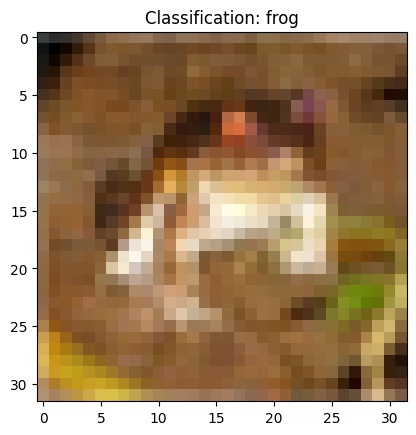

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')
i = 100
x_train = x_train[:100, :].transpose(0, 3, 1, 2).astype('float32')
x_test = x_test[:100, :].transpose(0, 3, 1, 2).astype('float32')
y_train = y_train[:100, :].astype('float32')
y_test = y_test[:100, :].astype('float32')

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

path = '../'

class Model(torch.nn.Module):
        """
        Create model for pytorch.
        Here the model does not use maxpooling. Needed for certification tests.
        """

        def __init__(self):
            super(Model, self).__init__()

            self.conv = torch.nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), stride=(3, 3)
            )

            self.fullyconnected = torch.nn.Linear(in_features=1600, out_features=10)

            self.relu = torch.nn.ReLU()

            w_conv2d = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "W_CONV2D_NO_MPOOL_CIFAR10.npy",
                )
            )
            b_conv2d = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "B_CONV2D_NO_MPOOL_CIFAR10.npy",
                )
            )
            w_dense = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "W_DENSE_NO_MPOOL_CIFAR10.npy",
                )
            )
            b_dense = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "B_DENSE_NO_MPOOL_CIFAR10.npy",
                )
            )

            self.conv.weight = torch.nn.Parameter(torch.Tensor(w_conv2d))
            self.conv.bias = torch.nn.Parameter(torch.Tensor(b_conv2d))
            self.fullyconnected.weight = torch.nn.Parameter(torch.Tensor(w_dense))
            self.fullyconnected.bias = torch.nn.Parameter(torch.Tensor(b_dense))

        # pylint: disable=W0221
        # disable pylint because of API requirements for function
        def forward(self, x):
            """
            Forward function to evaluate the model
            :param x: Input to the model
            :return: Prediction of the model
            """
            x = self.conv(x)
            x = self.relu(x)
            x = x.reshape(-1, 1600)
            x = self.fullyconnected(x)
            x = torch.nn.functional.softmax(x, dim=1)
            return x

# Define the network
model = Model()

# Define a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Get classifier
jptc = JaticPyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 32, 32), nb_classes=10, clip_values=(0, 1), labels=labels
)
plt.imshow(x_train[0].transpose(1,2,0))
_ = plt.title(f'Classification: {labels[np.argmax(jptc(x_train[[0]]).logits, axis=1)[0]]}')

## 3. Define the patch attack
In the following cell:
- we set hyperparameters for our patch attack
    - scale_min and scale_max are the max and min values we want our patch to scale to. Smaller patches can be more discrete within an image, but larger patches are more powerful
    - rotation_max is the max value to rotate the patch as in some instances
    - patch_shape is the size of the patch, in this case we have set the patch to be smaller than half the image
    - patch_location is the location of the patch, if not specified, random locations will be used - in this case we have selected the bottom right hand corner of the image
    - targeted is a boolean to indicate if we want the patch to generate a specific target class

In [3]:
batch_size = 16
scale_min = 0.3
scale_max = 1.0
rotation_max = 0
learning_rate = 5000.
max_iter = 2000
patch_shape = (3, 14, 14)
patch_location = (18,18)

ap = JaticAttack(AdversarialPatchPyTorch(estimator=jptc, rotation_max=rotation_max, patch_location=patch_location,
                      scale_min=scale_min, scale_max=scale_max, patch_type='square',
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=patch_shape, verbose=False, targeted=True))

## 4. Execute the attack
In the following cell:
- we extract 10 images from the CIFAR-10 dataset
- as we have defined a targeted adversarial patch attack, we define the target class which we want the patch to force the classifier to predict
- we choose a 'bird' as the target class
- we run the attack, passing in 10 images, and 10 labels of 'bird'
- the output of the attack contains 
    1. the adversarial patch that has been generated (including the mask)
    2. the 10 CIFAR-10 images, with the patch applied at the location we have specified

/Users/kieranfraser/git/work/cdao/gitlab/adversarial-robustness-toolbox-jatic/env/lib/python3.10/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/Users/kieranfraser/git/work/cdao/gitlab/adversarial-robustness-toolbox-jatic/env/lib/python3.10/site-packages/torchvision/transforms/functional.py:724: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


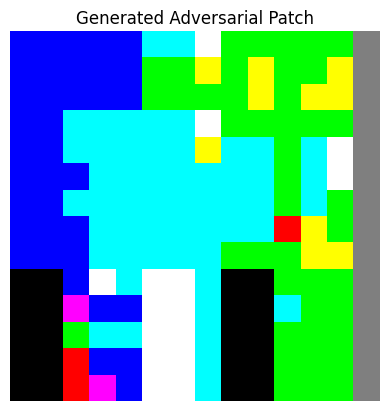

-------------


In [4]:
images = x_train[:10]
y_one_hot = np.zeros(len(labels))
y_one_hot[2] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))
data = {'image': images, 'label': y_target}

attack_output = ap.run_attack(data=data)
patch, patch_mask = attack_output.adversarial_patch

plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
_ = plt.title('Generated Adversarial Patch')
plt.show()
print('-------------')

## 5. Conclusions
In the following cell:
- we extract the patched images from the output
- loop through the 10 images
- in each case, print the patched image and the predictions for all classes
- we highlight the top prediction
- as expected, in most cases, the prediction is now the target class: 'bird'

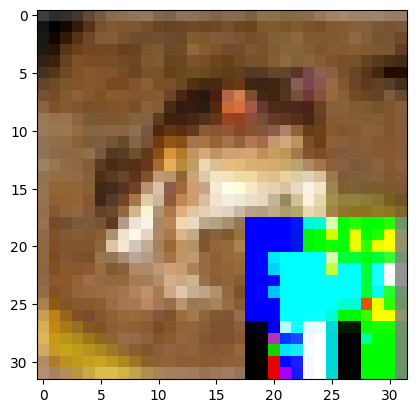

airplane: 6.81%
automobile: 0.41%
bird: 50.46% <--- Top prediction
cat: 10.78%
deer: 12.54%
dog: 4.8%
frog: 11.2%
horse: 2.91%
ship: 0.03%
truck: 0.06%
-------------


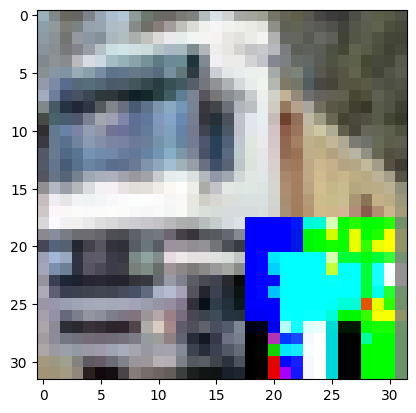

airplane: 5.96%
automobile: 9.38%
bird: 65.19% <--- Top prediction
cat: 2.59%
deer: 3.34%
dog: 2.45%
frog: 0.16%
horse: 5.9%
ship: 0.62%
truck: 4.41%
-------------


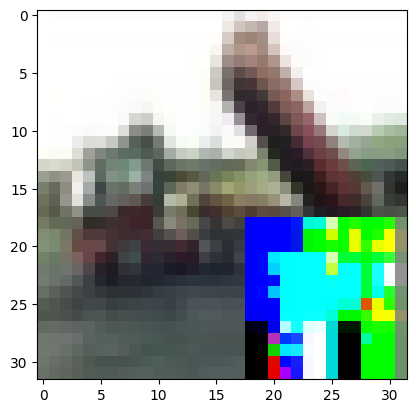

airplane: 16.61%
automobile: 2.14%
bird: 54.79% <--- Top prediction
cat: 4.8%
deer: 2.69%
dog: 0.85%
frog: 1.25%
horse: 6.45%
ship: 0.85%
truck: 9.57%
-------------


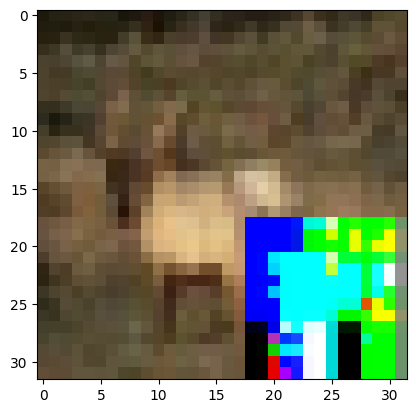

airplane: 4.46%
automobile: 0.32%
bird: 60.89% <--- Top prediction
cat: 3.31%
deer: 21.8%
dog: 1.5%
frog: 7.04%
horse: 0.48%
ship: 0.15%
truck: 0.05%
-------------


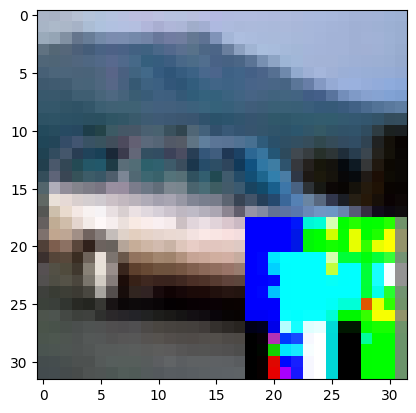

airplane: 67.96% <--- Top prediction
automobile: 15.27%
bird: 4.33%
cat: 0.08%
deer: 0.67%
dog: 0.01%
frog: 0.03%
horse: 0.22%
ship: 4.99%
truck: 6.43%
-------------


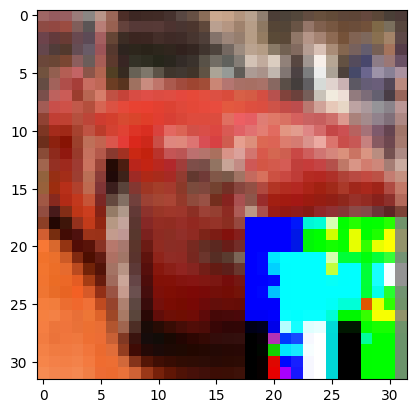

airplane: 3.06%
automobile: 5.02%
bird: 17.41%
cat: 20.78% <--- Top prediction
deer: 12.15%
dog: 11.23%
frog: 16.97%
horse: 10.48%
ship: 0.01%
truck: 2.9%
-------------


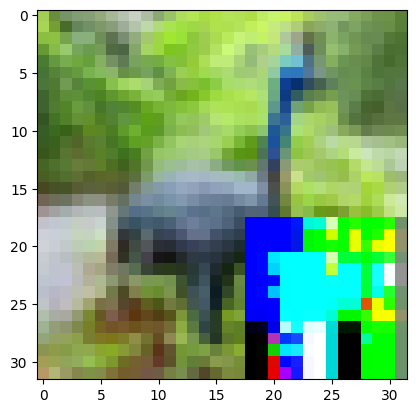

airplane: 2.09%
automobile: 0.65%
bird: 85.79% <--- Top prediction
cat: 0.21%
deer: 8.03%
dog: 0.13%
frog: 2.79%
horse: 0.12%
ship: 0.03%
truck: 0.17%
-------------


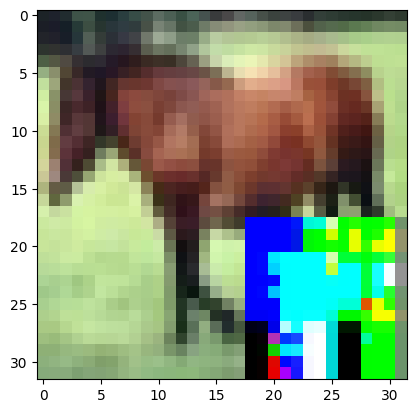

airplane: 0.65%
automobile: 0.02%
bird: 55.98% <--- Top prediction
cat: 2.23%
deer: 13.27%
dog: 3.36%
frog: 3.02%
horse: 21.47%
ship: 0.0%
truck: 0.02%
-------------


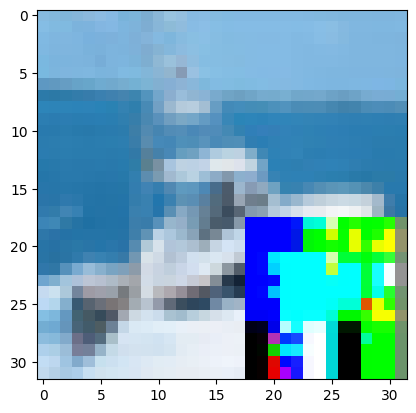

airplane: 22.29%
automobile: 0.27%
bird: 72.86% <--- Top prediction
cat: 0.09%
deer: 3.6%
dog: 0.01%
frog: 0.0%
horse: 0.05%
ship: 0.61%
truck: 0.22%
-------------


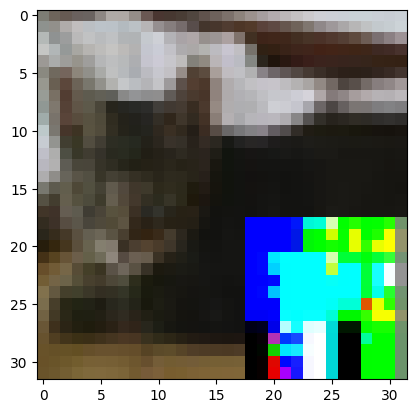

airplane: 4.59%
automobile: 2.36%
bird: 63.48% <--- Top prediction
cat: 2.94%
deer: 13.76%
dog: 1.72%
frog: 2.29%
horse: 7.24%
ship: 0.03%
truck: 1.59%
-------------


In [5]:
patched_images = attack_output.adversarial_examples
for patched_image in patched_images:
    plt.imshow(patched_image.transpose(1,2,0))
    plt.show()
    preds = jptc(patched_image).logits.ravel()
    for i, label in enumerate(labels):
        if np.argmax(preds) == i:
            print(f'{label}: {(preds[i]*100).round(2)}% <--- Top prediction')
        else:
            print(f'{label}: {(preds[i]*100).round(2)}%')
    print('-------------')

## 6. Next Steps
- Load your own data and model and experiment with the adversarial patch
- Try changing the location and shape of the patch, noting that different locations result in different confidence values
    - Hint: play with locations which fully obscure or slightly cover objects of interest and note the difference when the patch does not cover these objects
- Experimenting with the hyperparameters
    - are circle patches more effective than square patches?
    - what size patches are more effective?
    - if you increase the number of iterations, is the patch more powerful?
- 